# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, LinearSVC
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc,isnan, udf, isnull,sum,isnan,when, count, countDistinct,sum as Fsum,max as Fmax
from pyspark.sql import Window

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("capstone_project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#data_path = "mini_sparkify_event_data.json"
#user_event = spark.read.json(data_path)
#df = user_event

In [4]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [7]:
# count the number of rows
print(df.count())

286500


In [8]:
# count the number of columns
print(len(df.columns))

18


In [9]:
def info(df):
    df_info = pd.DataFrame(columns = ['Feature','#Nullvalues','#Empetystring','#NonNullvalues','%Non-nullvalues'])
    #Check the number of null rows in each column
    #print("Feature : Null row count : emptystring_count : Non-Null row count: Non-null precentage")
    i = 0
    row_count = df.count()
    for col in df.columns:
        null_count = df.filter(isnull(df[col])).count()
        emptystring_count = df.filter(df[col].isin('')).count()
        df_info.loc[i] = [col,null_count,emptystring_count,(row_count-null_count),(row_count-null_count)/row_count]
        i +=1
    print(df_info)

In [10]:
info(df)

          Feature #Nullvalues #Empetystring #NonNullvalues  %Non-nullvalues
0          artist       58392             0         228108         0.796188
1            auth           0             0         286500         1.000000
2       firstName        8346             0         278154         0.970869
3          gender        8346             0         278154         0.970869
4   itemInSession           0             0         286500         1.000000
5        lastName        8346             0         278154         0.970869
6          length       58392             0         228108         0.796188
7           level           0             0         286500         1.000000
8        location        8346             0         278154         0.970869
9          method           0             0         286500         1.000000
10           page           0             0         286500         1.000000
11   registration        8346             0         278154         0.970869
12      sess

In [11]:
# drop any cells with missing user id or session id
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [12]:
#Remove records with empty userId
df = df.filter(df['userId'] != '')

In [13]:
print((df.count(), len(df.columns)))

(278154, 18)


In [14]:
# Change the time format of ts and registration in the dataframe
change_time_format = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("tsDateColumn", change_time_format(df.ts))
df = df.withColumn("registrationDateColumn", change_time_format(df.registration))

# Exploratory Data Analysis


In [15]:
#set seaborn style
sns.set(style="whitegrid")

In [16]:
#Descriptive stats
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


### Define Churn

Once I have done some preliminary analysis, I create the Churn column to be used as a label for my model. I suggest that I can  use the Cancellation Confirmation events to define my churn, which happens for both paid and free users.

In [17]:
#Since I described churn as users who have the cancelation confirmation in the dataset, I add a new column called "churnInfo" as a flag for the customers who have churned.

# Add the Churn column
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churnInfo", flag_cancel_event("page"))

# Flag all the rows for the customers who churned.
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churnInfo", Fsum("churnInfo").over(windowval))

In [18]:
#Example of Cancellation record
df.filter("page = 'Cancellation Confirmation'").head(1)

[Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='GET', page='Cancellation Confirmation', registration=1533157139000, sessionId=174, song=None, status=200, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', tsDateColumn='2018-10-12 04:35:18', registrationDateColumn='2018-08-01 20:58:59', churnInfo=1)]

### Explore Data

Once I have defined churn, I perform some exploratory data analysis to observe the behavior of users who have stayed vs. users who have churned. I can start by exploring aggregates on these two groups of users, by observing how much of a specific action they have experienced on a given time unit or number of songs played.

### Definititon of Churn

Customer churn is one of the most important metrics for a business.  Customer churn is the percentage of customers that stopped using our company's product or service during a certain time frame.


We can calculate churn rate by dividing the number of customers we lost during that time period  by the number of customers we had at the beginning of that time period.

### Why Do Customers Churn?

There are a few likely causes for churn:
 
- Customer no longer values the product

- Motivating factors to use the product no longer exists

- Customer frustrated with product user experience

- The product lacks a mandatory capability required by the user

- Value to the customer does not justify the expense

- The customer has found/switched to an alternative solution

- Damage to product reputation

There are 225 unique userIds
+---------+-----+
|churnInfo|count|
+---------+-----+
|        0|  173|
|        1|   52|
+---------+-----+



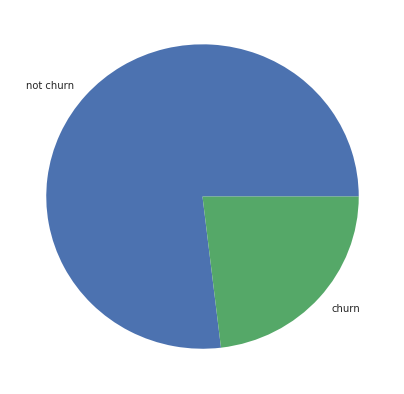

In [19]:
print("There are " + str(df.dropDuplicates(['userId']).count()) + " unique userIds")

# count how many users churn vs the others
churn = df.select(["userId", "churnInfo"]).dropDuplicates().groupBy("churnInfo").count()

churn.show()

# The ratio of users who churn vs. others
pd_df = churn.toPandas()
fig=plt.figure(figsize=(7,7))
plt.pie(x=pd_df["count"], labels=["not churn","churn"]);

Approximately a quarter of the users seem to have churned.

### Churn Ratios Depending on Number of Songs

In [20]:
#Comparison of those who churn and those who do not, by the number of songs played

df.select("*").where(df.page == "NextSong").groupby("churnInfo").agg(count("churnInfo")).show()


+---------+----------------+
|churnInfo|count(churnInfo)|
+---------+----------------+
|        0|          191714|
|        1|           36394|
+---------+----------------+



+---------+-------------------------------------------+
|churnInfo|(count(churnInfo) / count(DISTINCT userId))|
+---------+-------------------------------------------+
|        0|                         1108.1734104046243|
|        1|                          699.8846153846154|
+---------+-------------------------------------------+

None


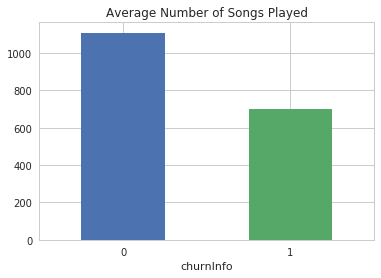

In [21]:
#The above data does not seem meaningful. It is more accurate to analyze this on the average number of songs played for each group.

print(df.select("*").where(df.page == "NextSong").groupby("churnInfo").agg(count("churnInfo")/countDistinct("userId")).show())

avg_songs_played = df.select("*").where(df.page == "NextSong") \
                                .groupby("churnInfo").agg(count("churnInfo")/countDistinct("userId")).toPandas()

plt.figure(figsize=(10,6))
avg_songs_played.plot.bar(x='churnInfo', y='(count(churnInfo) / count(DISTINCT userId))', rot=0, legend= None)
plt.title('Average Number of Songs Played');
plt.show()

### Churn Ratios Depending on Level

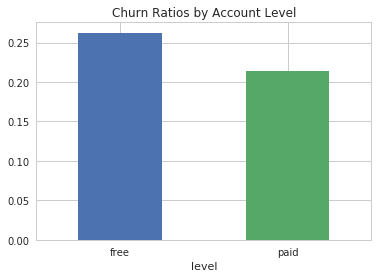

In [22]:
# Let's analyze the effect of free or paid subscription on churn.

churn_percent_by_level = df.dropDuplicates(['userId']).groupby(["level"]).agg(sum('churnInfo')/count('userId')).toPandas()

churn_percent_by_level.plot.bar(x='level', y='(sum(churnInfo) / count(userId))', rot=0, legend= None)
plt.title('Churn Ratios by Account Level');
plt.show()


The free users are slightly more likely to churn than paid users

### Churn Ratios Depending on Gender

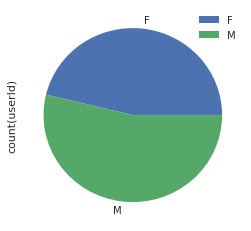

In [23]:
# Lets check the gender distribution in the dataset
gender_distribution = df.dropDuplicates(['userId']).groupby('gender').agg(count('userId')).toPandas()
gender_distribution.set_index('gender').plot.pie(y='count(userId)', figsize=(4, 4))

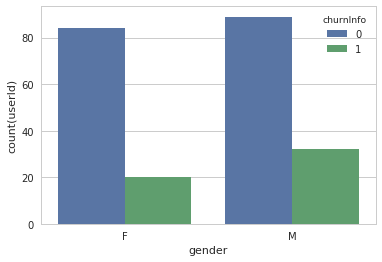

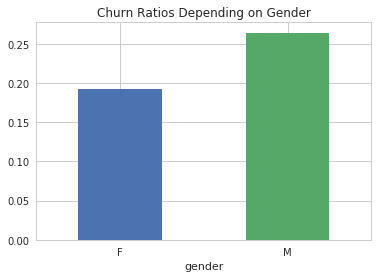

In [24]:
# Lets compare the genders of customers who churned and did not churn
churn_by_gender = df.dropDuplicates(['userId']).groupby(['churnInfo', "gender"]).agg(count('userId')).toPandas()
sns.barplot(data = churn_by_gender, x='gender', y='count(userId)', hue='churnInfo')

churn_percent_by_gender = df.dropDuplicates(['userId']).groupby(["gender"]).agg(sum('churnInfo')/count('userId')).toPandas()
churn_percent_by_gender.plot.bar(x='gender', y='(sum(churnInfo) / count(userId))', rot=0, legend= None)
plt.title('Churn Ratios Depending on Gender');
plt.show()

The Male population is more likely to churn, relative to the total number of users in their category

### Churn Ratios Depending on Diversity

In [25]:
# show total number of different artists that each user listens to
df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist", "churnInfo"]).dropDuplicates() \
    .groupBy(["churnInfo", "userId"]).agg(count("artist")) \
    .show()

+---------+------+-------------+
|churnInfo|userId|count(artist)|
+---------+------+-------------+
|        0|100010|          252|
|        0|200002|          339|
|        1|   125|            8|
|        0|   124|         2232|
|        1|    51|         1385|
|        0|     7|          142|
|        0|    15|         1302|
|        1|    54|         1744|
|        0|   155|          643|
|        1|100014|          233|
|        0|   132|         1299|
|        0|   154|           78|
|        1|   101|         1241|
|        0|    11|          534|
|        0|   138|         1332|
|        0|300017|         2070|
|        1|100021|          207|
|        1|    29|         1804|
|        0|    69|          865|
|        0|   112|          195|
+---------+------+-------------+
only showing top 20 rows



+---------+------------------+
|churnInfo|avg(count(artist))|
+---------+------------------+
|        0| 749.7861271676301|
|        1| 518.6923076923077|
+---------+------------------+



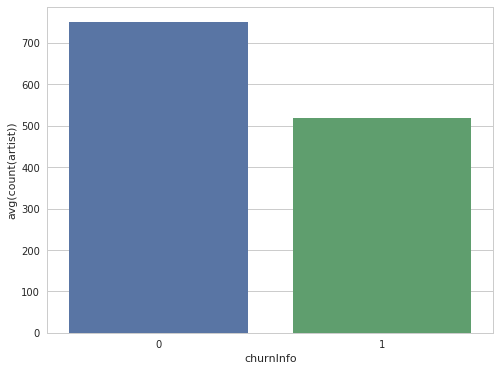

In [26]:
# show average number of different artists that users listen to between users who churn vs. users who do not churn
diversity = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist", "churnInfo"]).dropDuplicates() \
    .groupBy(["churnInfo", "userId"]).agg(count("artist")) \
    .groupBy("churnInfo").agg(avg("count(artist)"))

diversity.show()

# plot the churn by diversity information
pd_df = diversity.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churnInfo", y="avg(count(artist))", data=pd_df);

We observe that users who churn listen to fewer artists. This may be related to the fact that they spend less time in the system.

+---------+------------------+
|churnInfo|avg(count(artist))|
+---------+------------------+
|        0| 70.10344827586206|
|        1| 65.69171483622351|
+---------+------------------+



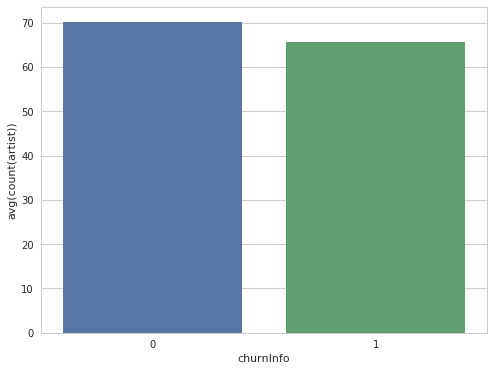

In [27]:
# show average number of different artists per session that users listen to between users who churn vs. users who do not churn
diversity_per_session = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "sessionId", "artist", "churnInfo"]).dropDuplicates() \
    .groupBy(["churnInfo", "userId", "sessionId"]).agg(count("artist")) \
    .groupBy("churnInfo").agg(avg("count(artist)"))

diversity_per_session.show()

# plot the churn by diversity per sessioninformation
pd_df = diversity_per_session.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churnInfo", y="avg(count(artist))", data=pd_df);

After this graph, we can say that users who churn listen to fewer artists per session.

In [28]:
# show highest number of times the same artist was played by each user in each session
df.filter(df["artist"].isNotNull()) \
    .groupBy(["churnInfo", "sessionId", "userId", "artist"]).count() \
    .groupBy(["churnInfo","userId", "sessionId"]).agg(Fmax("count")) \
    .orderBy("max(count)", ascending=False).show()

+---------+------+---------+----------+
|churnInfo|userId|sessionId|max(count)|
+---------+------+---------+----------+
|        0|   115|      316|        12|
|        0|    91|     1840|        12|
|        0|    61|      529|        10|
|        0|    41|      377|         9|
|        0|   132|     1494|         8|
|        0|    39|     1052|         7|
|        0|   100|      556|         7|
|        0|    89|     1271|         7|
|        1|   101|      635|         7|
|        0|   128|     2206|         7|
|        0|300002|      436|         7|
|        0|    25|      827|         7|
|        0|   124|      708|         7|
|        0|    42|     1646|         7|
|        0|     6|     1199|         7|
|        0|200014|      361|         7|
|        0|    95|      541|         7|
|        1|   103|     1117|         7|
|        0|   124|     1394|         7|
|        0|   138|     1305|         7|
+---------+------+---------+----------+
only showing top 20 rows



+---------+------------------+
|churnInfo|   avg(max(count))|
+---------+------------------+
|        0|1.8875391849529781|
|        1|1.8439306358381502|
+---------+------------------+



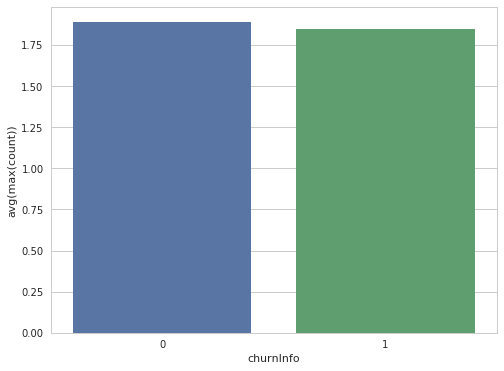

In [29]:
# show average highest number of times the same artist was played by each user in each session between users who churn vs. users who do not churn
repeat_artist_per_session = df.filter(df["artist"].isNotNull()) \
    .groupBy(["churnInfo", "sessionId", "userId", "artist"]).count() \
    .groupBy(["churnInfo", "userId", "sessionId"]).agg(Fmax("count")) \
    .groupBy("churnInfo").agg(avg("max(count)"))

repeat_artist_per_session.show()


# plot the churn by diversity per session
pd_df = repeat_artist_per_session.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churnInfo", y="avg(max(count))", data=pd_df);

According to the graph, there is no apparent difference between the users who churn and remain on the system compared to the number of listening to the songs of the same artist

### Length of Song

+------+---------+------------------+
|userId|churnInfo|       avg(length)|
+------+---------+------------------+
|100010|        0|  243.421444909091|
|200002|        0|242.91699209302323|
|   125|        1|       261.1391375|
|   124|        0|248.17653659965666|
|    51|        1| 247.8805508289908|
|     7|        0|253.56058066666665|
|    15|        0|249.37701452978044|
|    54|        1|250.38539934530132|
|   155|        0|242.41377060975574|
|100014|        1| 263.4376345525294|
|   132|        0|250.58034431535262|
|   154|        0|245.95266559523813|
|   101|        1| 249.0061294769059|
|    11|        0|246.78510516228766|
|   138|        0|247.56032983574823|
|300017|        0|247.08341966134319|
|100021|        1|250.57902452173914|
|    29|        1|249.18017257925987|
|    69|        0|254.27913390222233|
|   112|        0|246.80347251162794|
+------+---------+------------------+
only showing top 20 rows

+---------+------------------+
|churnInfo|       avg(length)|


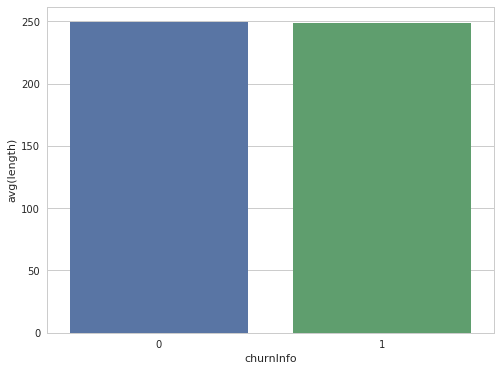

In [30]:
# show the average length of listening each song per user
df.filter(df["artist"].isNotNull()) \
    .groupBy(["userId", "churnInfo"]).agg(avg("length")) \
    .show()


# show the average length of listening each song between users who churn vs. users who do not churn
length = df.filter(df["artist"].isNotNull()) \
    .groupBy("churnInfo").agg(avg("length"))

length.show()


# plot the average length of songs information
pd_df = length.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churnInfo", y="avg(length)", data=pd_df);

There is no significant difference between the length of the songs listened by the two user groups.

## Actions in the Dataset

+---------+--------------------+------+--------------------+
|churnInfo|                page| count|             percent|
+---------+--------------------+------+--------------------+
|        0|    Submit Downgrade|    54| 2.31471559003815E-4|
|        0|      Submit Upgrade|   127|5.443868146941575E-4|
|        0|               Error|   220|  9.4303227742295E-4|
|        0|       Save Settings|   252| 0.00108020060868447|
|        0|             Upgrade|   387|0.001658879506194...|
|        0|               About|   439|0.001881778044493...|
|        0|                Help|  1215|0.005208110077585837|
|        0|            Settings|  1244| 0.00533241887779159|
|        0|           Downgrade|  1718|0.007364224784602855|
|        0|         Thumbs Down|  2050|0.008787346221441126|
|        0|              Logout|  2673|0.011457842170688843|
|        0|         Roll Advert|  2966|0.012713789703802134|
|        0|          Add Friend|  3641|0.015607184191349823|
|        0|     Add to P

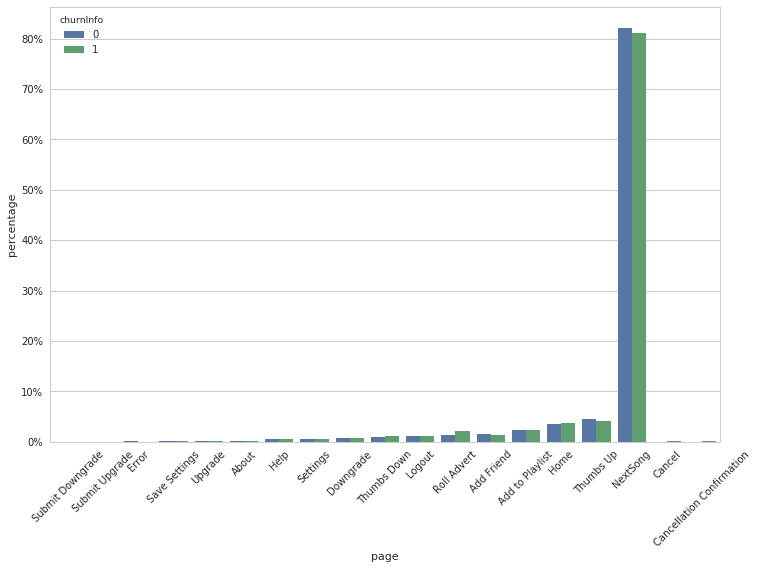

In [31]:
# comparison of the pages between the users who churn vs. users who do not churn
pages = df.groupBy(["churnInfo","page"]).count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churnInfo"))) \
    .orderBy(["churnInfo","percent"])

pages.show(40)


# plot the churn by pages information
pd_df = pages.toPandas()
fig=plt.figure(figsize=(12,8))
sns.barplot(x="page", y="percent", hue="churnInfo", data=pd_df);
plt.xticks(rotation=45);

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

We see that the action "NextSong" is clearly dominant in the data.

+--------------------+--------------------+--------------------+--------------------+
|                page|       churn_percent|    no_churn_percent|               ratio|
+--------------------+--------------------+--------------------+--------------------+
|              Cancel|0.001159058487874...|                null|                null|
|    Submit Downgrade|2.006062767475035...| 2.31471559003815E-4|-0.13334373514027587|
|         Thumbs Down|0.011055634807417974|0.008787346221441126|  0.2581312410841654|
|                Home|0.037268188302425106| 0.03604955205966823| 0.03380447670306208|
|           Downgrade|0.007511590584878745|0.007364224784602855| 0.02001104048100255|
|         Roll Advert|0.021554029957203995|0.012713789703802134|  0.6953269213473097|
|              Logout| 0.01232614122681883|0.011457842170688843| 0.07578207512329405|
|       Save Settings|0.001292796005706134| 0.00108020060868447| 0.19681103242533338|
|Cancellation Conf...|0.001159058487874...|           

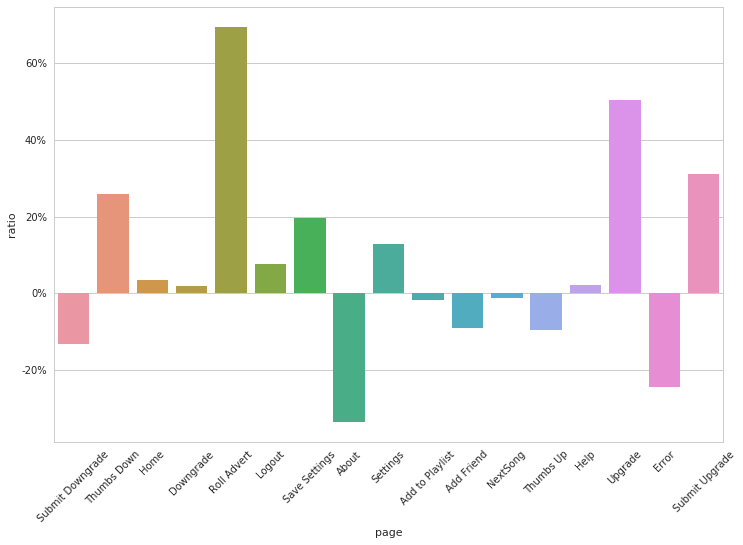

In [32]:
# show the comparison information in a more visual format
pages_churn = pages.filter(pages["churnInfo"]==1).select(["page","percent"]).withColumnRenamed('percent','churn_percent')
pages_no_churn = pages.filter(pages["churnInfo"]==0).select(["page","percent"]).withColumnRenamed('percent','no_churn_percent')

# join the tables to be able to compare the data
compare_pages = pages_churn.join(pages_no_churn, on="page", how="outer")
compare_pages = compare_pages.withColumn("ratio", col("churn_percent")/col("no_churn_percent")-1)

compare_pages.show()

# plot the pages that are more viewed in the group of "Churn" users
pd_df = compare_pages.toPandas().dropna()
fig=plt.figure(figsize=(12,8))
sns.barplot(x="page", y="ratio", data=pd_df);
plt.xticks(rotation=45);

# do some chart formatting
plt.ylabel("ratio");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

In the chart above, the values above 0 show the rate of pages that churn users visit more frequently. Values below 0 show the percentage of pages that churn users visit less.

The actions below are noticeably different between the 2 user groups:

- number of Thumbs Down
- number of Thumbs Up
- number of Roll Advert
- number of Add Friend
- number of Add to Playlist
- number of Upgrade

### Number of songs in each hour

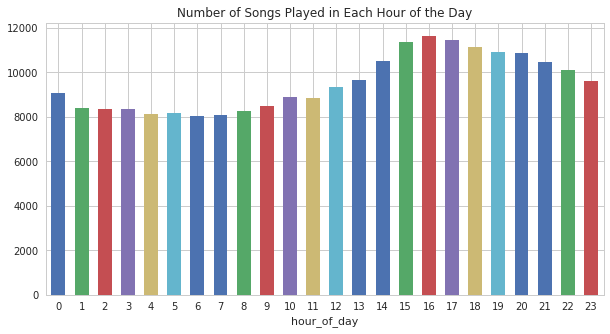

In [33]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)
df = df.withColumn("hour_of_day", get_hour(df.ts))

# Count the number of songs in each hour of day and store it in a pandas dataframe
songs_by_hour = df.select(['song', 'hour_of_day']).where(df.page == 'NextSong').groupby('hour_of_day').agg(count('song')) \
                                                                                    .orderBy('hour_of_day').toPandas()

# Change the datatype of "hour_of_day" column to integer and sort the rows on this column
songs_by_hour = songs_by_hour.astype({"hour_of_day": int})
songs_by_hour = songs_by_hour.sort_values(by='hour_of_day').reset_index(drop=True)

# Plot a chart to visualize the results
songs_by_hour.plot.bar(x='hour_of_day', y='count(song)', rot=0, legend= None, stacked=True, width=0.6, figsize=(10, 5))
plt.title('Number of Songs Played in Each Hour of the Day');
plt.show()

### Number of songs played by Top Users

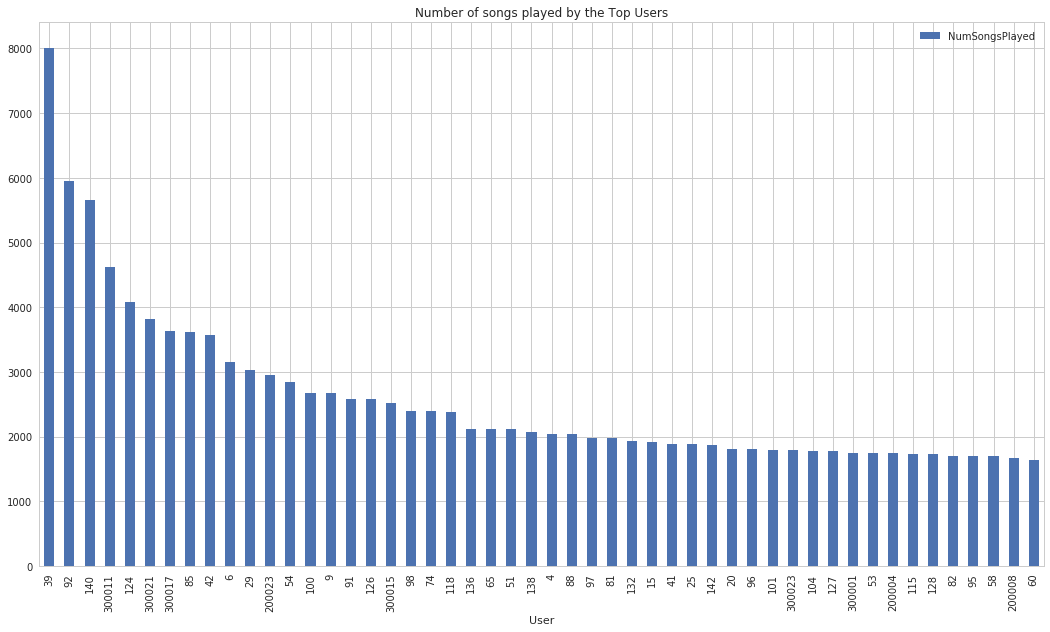

In [34]:
songs_df = df.filter(df.song != 'null').groupby('userId').agg(count(df.song).alias('NumSongsPlayed')).orderBy('NumSongsPlayed', ascending=False)
songs_df.toPandas().nlargest(50, 'NumSongsPlayed').plot(x='userId', kind='bar', figsize=(18,10))
plt.xlabel('User')
plt.title('Number of songs played by the Top Users')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features From "page"

In [35]:
# Here I define a function to extract features from the page column depending on different page categories
def feature_from_page(df, page_category):
    output = df.filter(df.page == page_category).groupby('userId') \
                .agg(count('page')).withColumnRenamed('count(page)', page_category)
    return output

# I make a list of the page categories I would like to add to my features dataframe
features_from_page_list = ['Add Friend', 'Add to Playlist', 'Thumbs Down',
                           'Thumbs Up', 'Roll Advert','Upgrade']


In [36]:
# I create a features dataframe.
features_df = df.select('userId').dropDuplicates()

# I add different features from the page column into features dataframe, I make outer join, in case I have null values
# I plan to fill them with zero values.
for feat in features_from_page_list:
    output = feature_from_page(df, feat)
    features_df = features_df.join(output, 'userId', 'outer')

### Features From "df columns"

#### Gender

In [37]:
# Define a user-defined function to create a new column to change categorical "gender" column to numeric.
gender_adder = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
# Apply the udf to create a new numeric "gender" column
df = df.withColumn('isMale', gender_adder(df.gender))

# Take the userId info and gender for adding the gender info into features dataframe
genders_of_users = df.dropDuplicates(['userId']).select(['userId', 'isMale']) \
                                                                .groupby('userId').agg(max('isMale')) \
                                                                .withColumnRenamed('max(isMale)', 'isMale')

# add the gender column into features dataframe
features_df = features_df.join(genders_of_users, 'userId', 'outer')


#### Level

In [38]:
# Define a user-defined function to create a new column to change categorical "level" column to numeric.
level_adder = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
# Apply the udf to create a new numeric "level" column
df = df.withColumn('isPaid', level_adder(df.level))

# Take the userId info and level for adding the level info into features dataframe
levels_of_users = df.dropDuplicates(['userId']).select(['userId', 'isPaid']) \
                                                                .groupby('userId').agg(max('isPaid')) \
                                                                .withColumnRenamed('max(isPaid)', 'isPaid')

# add the level column into features dataframe
features_df = features_df.join(levels_of_users, 'userId', 'outer')

#### Number of songs played

In [39]:

# Take the userId and number of songs they played
number_of_songs = df.select(['userId', 'page']).where(df.page == 'NextSong') \
                                .groupby('userId') \
                                .agg({'page':'count'}) \
                                .withColumnRenamed('count(page)', 'numberOfSongsPlayed')

# Add the number of songs column into features dataframe
features_df = features_df.join(number_of_songs, 'userId', 'outer')

#### Membership Duration

In [40]:
# I would like to add the membership duration for each of the users in the dataset
membership_duration_days = df.select(['userId', 'ts', 'registration']) \
                             .withColumn('membership_duration', (df.ts - df.registration)/(1000*60*60*24)) \
                                .groupby('userId') \
                                .agg({'membership_duration': 'max'}) \
                                .withColumnRenamed('max(membership_duration)', 'membership_duration')

# Add the duration of membership column into features dataframe
features_df = features_df.join(membership_duration_days, 'userId', 'outer')

#### Add churnInfo as label

In [41]:
# Take the userId and churnInfo for adding into features dataframe as a label
churn_label = df.dropDuplicates(['userId']).select(['userId', 'churnInfo']) \
                                                                .groupby('userId').agg(max('churnInfo')) \
                                                                .withColumnRenamed('max(churnInfo)', 'churnInfo')

# Add the number of songs column into features dataframe
features_and_label_df = features_df.join(churn_label, 'userId', 'outer')

In [42]:
# Fill the null values in the features dataframe with zero values
features_and_label_df = features_and_label_df.fillna(0)

In [43]:
features_and_label_df.show(n=10)

+------+----------+---------------+-----------+---------+-----------+-------+------+------+-------------------+-------------------+---------+
|userId|Add Friend|Add to Playlist|Thumbs Down|Thumbs Up|Roll Advert|Upgrade|isMale|isPaid|numberOfSongsPlayed|membership_duration|churnInfo|
+------+----------+---------------+-----------+---------+-----------+-------+------+------+-------------------+-------------------+---------+
|100010|         4|              7|          5|       17|         52|      2|     0|     0|                275|  55.64365740740741|        0|
|200002|         4|              8|          6|       21|          7|      2|     1|     0|                387|  70.07462962962963|        0|
|   125|         0|              0|          0|        0|          1|      0|     1|     0|                  8|  71.31688657407408|        1|
|   124|        74|            118|         41|      171|          4|      0|     0|     1|               4079| 131.55591435185184|        0|
|    5

In [44]:
# I make a list of features names I would like to vectorize in the dataset
features = ['Add Friend', 'Add to Playlist', 'Thumbs Up', 'Thumbs Down',
            'Roll Advert', 'isMale', 'isPaid', 'numberOfSongsPlayed', 'membership_duration']

# I create the vector assembler and use it to vectorize the feature
assembler = VectorAssembler(inputCols = features, outputCol = 'vectorized_Features')
features_and_label_df = assembler.transform(features_and_label_df)

In [45]:
# I scale the features in the dataset 
scaler = StandardScaler(inputCol = 'vectorized_Features', outputCol = 'scaled_vectorized_feaures')
scalerModel = scaler.fit(features_and_label_df)
features_and_label_df = scalerModel.transform(features_and_label_df)

In [46]:
# I create the data that I will be using to train and test my model. The model_date consists of two parts:
    # 1. vectorized and scaled features
    # 2. labels
model_data = features_and_label_df.select(features_and_label_df['scaled_vectorized_feaures'].alias("features"),
                                         features_and_label_df['churnInfo'].alias("label"))

# Modeling

In [47]:
# Break the dataset into training and testing sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

Since we have a classification problem and we have a relatively small dataset, we can use f1 score as an indicator to compare accuracy of different algoritms.

In [48]:
# Create a single evaluator for comparing accuracy of different algoritms I train in the following cells
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

## Logistic Regression Classifier

In [49]:
# Define the model
lr = LogisticRegression(elasticNetParam=0)

# Define the parameter alternatives to be tested
paramGrid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.0, 0.1]) \
            .addGrid(lr.maxIter, [10, 50]) \
            .build()


# Define cross-validation
crossval_lr = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = evaluator,
                          numFolds =3)

# Train the model with train dataset
lr_model = crossval_lr.fit(train)

# Make predictions with the model, by using test dataset
lr_preds = lr_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models.
lr_f1_score = evaluator.evaluate(lr_preds)
print('Logistic Regression F1-Score: {}'.format(round(lr_f1_score*100,2)))

Logistic Regression F1-Score: 71.49


## Random Forest Classifier

In [50]:
# Define the model
rf = RandomForestClassifier()

# Define the parameter alternatives to be tested
paramGrid_rf = ParamGridBuilder() \
            .addGrid(rf.numTrees, [20, 30]) \
            .addGrid(rf.maxDepth, [5, 10]) \
            .build()


# Define cross-validation
crossval_rf = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = evaluator,
                          numFolds =3)

# Train the model with train dataset
rf_model = crossval_rf.fit(train)

# Make predictions with the model, by using test dataset
rf_preds = rf_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models. 
rf_f1_score = evaluator.evaluate(rf_preds)
print('Random Forest F1-Score: {}'.format(round(rf_f1_score*100,2)))

Random Forest F1-Score: 80.06


## Linear SVC Classifier

In [51]:
# Define the model
lsvc = LinearSVC()

# Define the parameter alternatives to be tested
paramGrid_lsvc = ParamGridBuilder() \
            .addGrid(lsvc.regParam, [0.01]) \
            .addGrid(lsvc.maxIter, [5]) \
            .build()
        

# Define cross-validation
crossval_lsvc = CrossValidator(estimator = lsvc,
                          estimatorParamMaps = paramGrid_lsvc,
                          evaluator = evaluator,
                          numFolds =3)


# Train the model with train dataset
lsvc_model = crossval_lsvc.fit(train)

# Make predictions with the model, by using test dataset
lsvc_preds = lsvc_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models.
lsvc_f1_score = evaluator.evaluate(lsvc_preds)
print('Linear SVC F1-Score: {}'.format(round(lsvc_f1_score*100,2)))

Linear SVC F1-Score: 54.59


## Gradient-Boosted Tree Classifier

In [52]:
# Define the model
gbt = GBTClassifier()

# Define the parameter alternatives to be tested
paramGrid_gbt = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [5, 10]) \
            .addGrid(gbt.maxIter, [10, 20]) \
            .build()
        

# Define cross-validation
crossval_gbt = CrossValidator(estimator = gbt,
                        estimatorParamMaps = paramGrid_gbt,
                        evaluator = evaluator,
                        numFolds =3)

# Train the model with train dataset
gbt_model = crossval_gbt.fit(train)

# Make predictions with the model, by using test dataset
gbt_preds = gbt_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models.
gbt_f1_score = evaluator.evaluate(gbt_preds)
print('Gradient-Boosted Tree F1-Score: {}'.format(round(gbt_f1_score*100,2)))

Gradient-Boosted Tree F1-Score: 68.5


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.